# <div align="center"><b> RAMP: AIRLINE CARRIERS PERFORMANCE </b></div>
---



<div style="text-align: center">
<center><b>Authors: Soumaya SABRY | Alexandre ZAJAC | Maxime LEPEYTRE | Olivier BOIVIN | Yann KERVELLA</b></center>

<center>
<img src="https://github.com/alexZajac/airlines_performance/blob/master/images/airplane.png?raw=1" width="800px" /></center>
</div>

# Table of contents
1. [Introduction](#Introduction) 
    - [Download the data](#Download)
    - [The Challenge](#Challenge) 
    - [Where does the data come from ?](#where)
      - [Main Dataset](#Main)
      - [Weather Data](#weather)
      - [Tweets Data](#twitter)
2. [Data exploration](#explo)
    - [Requirements](#requirements)
    - [Airlines choice based on performance](#choice)
    - [Train Dataset Decomposition](#decomp) 
    - [Distance Groups Features](#distance)
    - [Top 5 Destination Features - Meteo](#meteo)
    - [Statistical Features](#stats)
    - [Top 1 Destination Frequency Feature](#top1)
    - [Seasonality of the Load Factor](#season)
3. [Performance metric](#metric)
4. [Ideas and starting kits](#ideas)
5. [Submission](#submission) 

# Introduction <a name="Introduction"></a>
---
What is the challenge ? Why it load factor useful ? Where was the data extracted ? 

## Download the data (optional) <a name="Download"></a>

If the data has not yet been downloaded locally, uncomment the following cell and run it. Be patient. This may take a few minutes. The download size is less than 150 MB.

In [2]:
!pip3 install -r requirements.txt

     |████████████████████████████████| 13.2 MB 98 kB/s 
  Created wheel for retrying: filename=retrying-1.3.3-py3-none-any.whl size=11430 sha256=76d246ccd6ac753449a6cff784b982431bba6f0c87004d56da957333acc6b67a
  Stored in directory: /home/alexzajac/.cache/pip/wheels/f9/8d/8d/f6af3f7f9eea3553bc2fe6d53e4b287dad18b06a861ac56ddf
Successfully built retrying


In [ ]:
!python download_data.py

Skipping existing file data/load_factor_seaso.csv
Skipping existing file data/T_Domestic_Segment_Original_All_Years.csv
Skipping existing file data/L_DISTANCE_GROUP_500.csv_
Skipping existing file data/L_AIRCRAFT_TYPE.csv_
Skipping existing file data/Other/wti.xlsx
Skipping existing file data/Other/Economic-Indicator_United-States-Unemployment-Rate__2-Jan-2021.xlsx
Skipping existing file data/Other/Economic-Indicator_United-States-ISM-Manufacturing-PMI_2-Jan-2021.xlsx
Skipping existing file data/airline_choice.csv
Skipping existing file data/train/y.csv
Skipping existing file data/train/X.csv
Skipping existing file data/test/X.csv
Skipping existing file data/test/y.csv
Skipping existing file data/T_100_Domestic_Segment_All_Years_Extended.csv
Skipping existing file data/tweets_dataset.csv
saved 0 files to data


You should now be able to find the `test` and `train` folders in the `data/` directory

## The Challenge <a name="Challenge"></a>

Recently, big oil companies like BP, Total, announced that they want to reach the goal of **zero carbon** emissions, following the declarations of the governments. 
During this period of Covid-19, the ecological transition has been accelerating as we can see more investments in the renewable energy sector and especially less investments in the oil sector. To achieve this goal, each sector must reduce its emissions.

We have chosen to focus our study on the airline industry. Following the  report of [IEA](https://www.iea.org/) (International Energy Agency), since 2000, commercial passenger flight activity has grown by about 5% per year, while CO2 emissions rose by 2% per year, thanks to operational and technical efficiency measures. The energy intensity of commercial passenger aviation has decreased 2.8% per year in average, but improvements have slackened over time. As we can see on this [figure](https://www.iea.org/data-and-statistics/charts/energy-intensity-of-passenger-aviation-in-the-sustainable-development-scenario-2000-2030) below, where it exposes the Sustainable Development Scenario (one RTK is generated when a metric tonne of revenue load is carried one km). 

<div style="text-align: center">
<img src="https://github.com/alexZajac/airlines_performance/blob/master/images/IEA_2.PNG?raw=1" width="800px" />
</div>

We uses the ICAO carbon calculator to understand which factors can impact the C02 emissions:



$ C_{O2} \; per \; pax = 3.16 * (total\;fuel*pax\;to\;freight\;factor)*(number\;of\;y-seats*pax\,load\;factor) $

We choose to focus on the load factor as 2020 impacted it through the pandemic
as shown in the figure below from the [report](https://ec.europa.eu/transport/sites/transport/files/legislation/com20200558_allocation_of_slots.pdf) from the commission to the european parliament and the council. We can see the average load factor for a pool of European air carriers dropped from 80% in week 9 to 26% in week 15. This is due not only to air carriers flying less, but the few remain underbooked. We want to focus our study on the load factor and its impacts on the C02 emissions.

We have chosen to focus our model on forecasting the evolution of the load factor. The aim of this forecast is to help airlines adapt their flight plans to optimize their load factor and reduce their emissions. During covid-19, their load factor is low and we want to find a way to recover from it by having a model capable of giving good enough predictions to anticipate the future.

<div style="text-align: center">
<img src="https://github.com/alexZajac/airlines_performance/blob/master/images/MeanLF.PNG?raw=1" width="800px" />
</div>


***What is the Passenger Load Factor ?***

$Load \space{Factor}  = \frac{RPM}{ASM}$

• RPM : Revenue Passenger Miles ($ RPM = Passengers * Distance $)

• ASM : Available Seat Miles ($ ASM = Available\space{Seats} * Distance $)

To calculate the load factor for a single flight, you can get rid of the distance term, however to calculate it over a month for a company, you've got to take into account the distance factor.

This factor is important for all transport system companies, as it assesses the performance. The majority of the revenue is made by selling tickets, to cover the high fixed costs and make profits. 

It is also important to maximize the load factor for environmental reasons, it maximizes the **fuel efficiency**. As passengers's weight represent a very low proportion of the total weight of an airplane, increasing the number of passengers lowers the fuel consumption per passengers.

Investors also look at the Airlines Load Factors as profitability indicators as airlines have very high fixed costs compared to railways companies for example. Having a high load factor is essential for any company's success. 
We can also notice that ASM is a useful metric to measure an airline's capacity to generate revenues.

We call "**break-even Load Factor**" the minimum load factor needed to cover the expenses for one flight.


# Your mission, if you accept it...

Simply put, you will get features/data for 20 different US airlines and your job is to predict the `LOAD_FACTOR` for the last year of data, for each of the 20 airlines. It is thus a **regression/forecasting task**, with multiple ways/features to enrich your dataset. Here is a visualization of what will happen with your predictions:

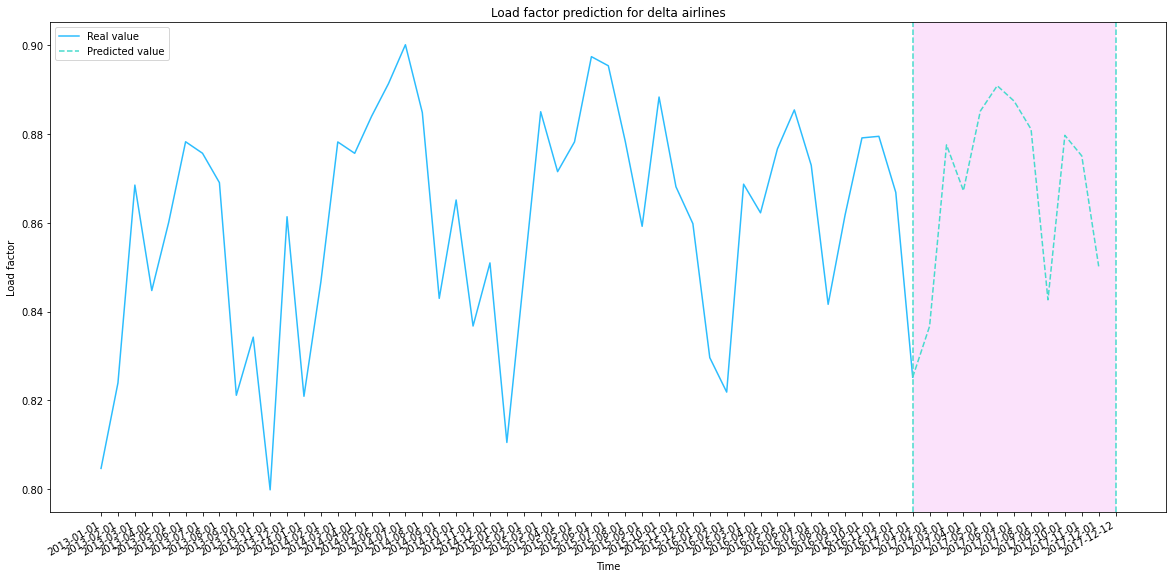

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv("data/train/features.csv", index_col=0)
df.set_index("DATE", inplace=True)

# example for delta airlines
load_factor = df[df["UNIQUE_CARRIER_NAME"] == "Delta Air Lines Inc."]["LOAD_FACTOR"]
known_value = load_factor[:"2017-01-01"]
y_true = load_factor["2016-12-12":]

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(known_value, label="Real value", c='#2CBDFE')
ax.plot(y_true, label="Predicted value", linestyle="dashed", c='#47DBCD')
ax.axvline("2017-01-01", linestyle="--", color='#47DBCD')
ax.axvline("2017-12-12", linestyle="--", color='#47DBCD')
ax.axvspan("2017-01-01", "2017-12-12", facecolor='#F3A0F2', alpha=0.3)
ax.set_xlabel("Time")
ax.set_ylabel("Load factor")
ax.set_title("Load factor prediction for delta airlines")
ax.legend()
fig.autofmt_xdate()
plt.show()

## What data can you play with ? <a name="where"></a>

The data is contained in an `AirlineData` class, which has 2 attributes:
- features: the Dataframe of features for all airlines (main dataset + weather data), described below.
- tweets: the Dataframe of tweets matching the dates of the features dataframe, described below.

### Main Dataset : Airlines Statistics from 2013 to 2019 <a name="Main"></a>

This dataset is a source of statistics on aviation, multimodal freight activity and transportation economics in the United States.

The dataset contains detailed informations on the flights for US Carriers like  `PASSENGERS, SEATS, PAYLOAD, DESTINATION_CITY, AIRCRAFT_TYPE, ...`
We gathered the informations by month and by companies and enriched the dataset with statistical features, temperatures, top destinations, etc... from there.

All the features are explained below in the data exploration part!

In [51]:
main_df = pd.read_csv("data/train/features.csv", index_col=0)
main_df = main_df[main_df.columns.difference(["TSUN", "TMAX", "SNOW", "PRCP", "TAVG", "WSPD"])]
main_df.head()

,194,26,339,35,359,406,416,461,482,530,608,612,614,616,617,619,622,623,624,625,626,627,629,631,634,637,638,644,650,654,655,656,673,674,675,676,677,678,687,694,696,698,699,721,722,723,819,822,837,838,839,887,888,...,NB_FLIGHTS,PMI,Price,Q1_FREIGHT,Q1_MAIL,Q1_PASSENGERS,Q1_PAYLOAD,Q3_FREIGHT,Q3_MAIL,Q3_PASSENGERS,Q3_PAYLOAD,STD_FREIGHT,STD_MAIL,STD_PASSENGERS,STD_PAYLOAD,TOP1_DEST,TOP1_PRCP,TOP1_SNOW,TOP1_TAVG,TOP1_TMAX,TOP1_TSUN,TOP1_WSPD,TOP2_DEST,TOP2_PRCP,TOP2_SNOW,TOP2_TAVG,TOP2_TMAX,TOP2_TSUN,TOP2_WSPD,TOP3_DEST,TOP3_PRCP,TOP3_SNOW,TOP3_TAVG,TOP3_TMAX,TOP3_TSUN,TOP3_WSPD,TOP4_DEST,TOP4_PRCP,TOP4_SNOW,TOP4_TAVG,TOP4_TMAX,TOP4_TSUN,TOP4_WSPD,TOP5_DEST,TOP5_PRCP,TOP5_SNOW,TOP5_TAVG,TOP5_TMAX,TOP5_TSUN,TOP5_WSPD,TOP_1_DEST_FQ,UNEMPLOYMENT,UNIQUE_CARRIER_NAME
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.0,0.0,0.0,0.00,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,315,50.7,97.41,0.00,0.0,153.50,96248.0,394.00,0.00,2092.50,1576126.0,867.332886,35.657436,1443.956635,9.696895e+05,"Charlotte, NC",150.7,0.0,24.723333,34.4,0.0,10.083333,"Philadelphia, PA",83.1,6.428571,2.657143,19.4,0.0,15.271429,"Washington, DC",126.3,0.0,21.138710,33.9,0.0,13.696774,"Boston, MA",100.0,0.000000,20.596667,35.6,0.0,14.920000,"Scranton/Wilkes-Barre, PA",76.1,0.000000,19.480000,33.3,0.0,9.056667,0.155556,7.8%,Air Wisconsin Airlines Corp
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.167,0.356,0.0,0.333,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.144,0.0,0.0,0.0,0.00,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,444,50.7,97.41,183.25,0.0,384.75,141475.0,11659.25,1.25,4185.25,1313780.0,47218.189711,29506.552452,3734.144798,1.200548e+06,"Seattle, WA",97.3,0.0,7.019355,16.1,0.0,12.438710,"Anchorage, AK",20.9,465.483871,-2.345161,5.6,0.0,8.900000,"Portland, OR",114.1,0.0,7.543333,17.8,0.0,11.816667,"Juneau, AK",256.4,0.000000,7.148387,13.3,0.0,12.970968,"Palm Springs, CA",0.0,0.000000,18.861290,34.4,0.0,6.703333,0.247748,7.8%,Alaska Airlines Inc.
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.048,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.012,0.940,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,482,50.7,97.41,0.00,0.0,340.00,90600.0,0.00,0.00,1377.00,306000.0,0.000000,0.000000,802.760251,1.869837e+05,"Las Vegas, NV",57.4,0.0,20.403333,32.8,0.0,13.340000,"Sanford, FL",96.7,0.000000,15.009677,28.3,0.0,12.758065,"Phoenix, AZ",7.8,0.0,13.846429,26.7,0.0,8.528571,"Wendover, UT",26.9,0.000000,3.453333,16.7,0.0,9.610000,"St. Petersburg, FL",228.3,0.000000,28.564516,34.4,0.0,8.448387,0.097510,7.8%,Allegiant Air
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.335,0.0,0.000,0.0,0.173,0.000,0.000,0.041,0.059,0.027,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.000,0.364,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,...,629,50.7,97.41,0.00,0.0,325.00,120200.0,6704.00,0.00,11808.00,4445700.0,139988.557494,12874.553621,9535.924198,3.240689e+06,"Dallas/Fort Worth, TX",88.6,0.0,10.266667,28.3,0.0,16.222581,"Chicago, IL",45.3,0.000000,13.587097,26.7,0.0,18.080645,"Miami, FL",322.9,0.0,27.774194,34.4,13909.0,12.438710,"Los Angeles, CA",6.1,0.000000,20.619355,35.0,0.0,9.480645,"New York, NY",128.8,21.935484,4.290323,22.8,0.0,20.238710,0.198728,7.8%,American Airlines Inc.
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026,0.120,0.0,0.000,0.0,0.115,0.025,0.005,0.000,0.035,0.005,0.0,0.0,0.000,0.0,0.0,0.0,0.04,0.000,0.141,0.073,0.0,0.0,0.0,0.0,0.0,0.0,0.016,0.159,0.009,0.226,0.0,0.0,0.0,0.0,0.005,0.0,0.0,0.0,0.0,0.0,0.0,...,2329,50.7,97.41,0.00,0.0,127.00,40770.0,3830.00,975.00,3665.00,1183920.0,46160.765928,20904.331090,5532.201728,1.838179e+06,"Atlanta, GA",149.7,0.0,17.023333,28.9,0.0,14.503333,"Minneapolis, 

### Additional Features : Weather Statistics <a name="weather"></a> 

On the one hand, snow, rain and crosswinds mean that air traffic controllers have to increase the gap between planes that are landing, reducing the number of aircraft that an airport can manage. The same weather can make it slower and more difficult for the planes to taxi between runway and terminal building. On the other hand, the average temperature and sunshine level on the arrival destination can influence the choice of passengers for a given carrier.

Your are given with the following features `tavg, tmax, tsun, snow, wspd and prcp` (as given [here](https://dev.meteostat.net/python/daily.html#data-structure)). It's your job to find if those features can enrich the forecast!

In [52]:
weather_df =  pd.read_csv("data/weather_dataset.csv", index_col=0)
weather_df.head()

,DEST_CITY_NAME,POINT,DATE,TAVG,TMAX,PRCP,SNOW,WSPD,TSUN
0,"Charlotte, NC","(35.2272086, -80.8430827)",2013-01-31,7.735484,25.0,109.3,0.000000,9.570968,0.0
1,"Charlotte, NC","(35.2272086, -80.8430827)",2013-02-28,6.142857,18.9,88.0,2.714286,10.396429,0.0
2,"Charlotte, NC","(35.2272086, -80.8430827)",2013-03-31,7.555172,26.1,87.4,0.000000,11.116129,0.0
3,"Charlotte, NC","(35.2272086, -80.8430827)",2013-04-30,16.173333,28.9,116.0,0.000000,11.650000,0.0
4,"Charlotte, NC","(35.2272086, -80.8430827)",2013-05-31,19.393548,30.6,76.3,0.000000,10.861290,0.0


### Additional Features : Twitter Data with web-scraping <a name="twitter"></a>

It's not uncommon to include Twitter data in machine learning challenges. Since we are forecasting a load factor, which is a proxy for the performance of an airline carrier, you are provided with a dataset of tweets for all the airlines from 2013 to 2019.

In [53]:
tweeter_df =  pd.read_csv("data/train/tweets.csv", index_col=0)
tweeter_df.head()

,USERNAME,TWEET,LIKES,RETWEETS,URL,REPLIES,UNIQUE_CARRIER_NAME,DATE
0,@VirginiaSent,Court rules 4 airline in pilot defamation clai...,0.0,0.0,https://twitter.com/VirginiaSent/status/428206...,0.0,Air Wisconsin Airlines Corp,2014-01-01
1,@LeeBerlik,Jury verdict in pilot's defamation action agai...,0.0,0.0,https://twitter.com/LeeBerlik/status/428194001...,0.0,Air Wisconsin Airlines Corp,2014-01-01
2,@Popehat,Supreme Court's Air Wisconsin Case Is About Ro...,2.0,4.0,https://twitter.com/Popehat/status/42819230902...,1.0,Air Wisconsin Airlines Corp,2014-01-01
3,@lsolum,"The Supreme Court’s Statutory Originalism, Mic...",0.0,0.0,https://twitter.com/lsolum/status/428187086160...,0.0,Air Wisconsin Airlines Corp,2014-01-01
4,@asmareeno,#US_Supreme_Court AIR WISCONSIN AIRLINES CORP....,0.0,0.0,https://twitter.com/asmareeno/status/428101249...,0.0,Air Wisconsin Airlines Corp,2014-01-01


# Data exploration <a name="explo"></a>

--- 
Let's understand the dataset !

### Requirements <a name = 'requirements'></a>

In [54]:
#!pip install -U -r requirements.txt --user

In [55]:
# Libraries
import numpy as np
import random
import plotly.graph_objects as go
from scipy.stats import pearsonr
import datetime
from tqdm.notebook import tqdm
from sklearn.preprocessing import StandardScaler
from dateutil.relativedelta import relativedelta
pd.options.mode.chained_assignment = None
pd.set_option('display.max_columns', 106)

In [56]:
# Graphical settings
CB91_Blue = '#2CBDFE'
CB91_Green = '#47DBCD'
CB91_Pink = '#F3A0F2'
CB91_Purple = '#9D2EC5'
CB91_Violet = '#661D98'
CB91_Amber = '#F5B14C'
color_list = [CB91_Blue, CB91_Pink, CB91_Green, CB91_Amber,
              CB91_Purple, CB91_Violet]
params = {"ytick.color" : "w",
          "xtick.color" : "w",
          'axes.labelsize' : 15,
          "axes.labelcolor" : "w",
          "axes.edgecolor" : "w",
          "axes.titlecolor": "w", 
          'figure.figsize': [20, 8], 
          'axes.prop_cycle': plt.cycler(color=color_list), 
          'figure.dpi' : 75, 
          'legend.fontsize': 10,
          'font.size': 15 
          }
plt.rcParams.update(params)

## Airlines choice based on their performance <a name= 'choice'></a>
---
It is important to notice that our raw main dataset of flights contains a lot of airlines (200+). We wanted to know if it was relevant to keep all of them inside our training dataset.

After a few data visualizations, it was clear for us that we would only keep the top airlines of our dataset. The criterias we chose for our selection were the total number of passengers, the total number of flights and the average monthly number of passenger over the period covered by our entire dataset.


In [57]:
main_df = pd.read_csv("data/T_Domestic_Segment_Original_All_Years.csv", index_col=0)
count_flights = main_df.groupby(['UNIQUE_CARRIER_NAME', 'DATE'])['PASSENGERS'].count().reset_index(name = 'NB_FLIGHTS')
count_flights_f = count_flights.groupby(['UNIQUE_CARRIER_NAME'])['NB_FLIGHTS'].mean().reset_index(name = 'MOY_NB_FLIGHTS').sort_values('MOY_NB_FLIGHTS', ascending = False)
tot_pass = count_flights_f.merge(main_df.groupby(['UNIQUE_CARRIER_NAME'])['PASSENGERS'].sum().reset_index(name = 'TOT_PASS_FLIGHTS').reset_index(drop=True), on= ['UNIQUE_CARRIER_NAME']).sort_values('TOT_PASS_FLIGHTS', ascending = False)
tot_nb_flights = tot_pass.merge(main_df.groupby(['UNIQUE_CARRIER_NAME'])['PASSENGERS'].count().reset_index(name = 'TOT_NB_FLIGHTS').reset_index(drop=True), on=['UNIQUE_CARRIER_NAME']).sort_values('TOT_NB_FLIGHTS', ascending = False)

We scaled our metrics using the `StandardScaler` of SKLearn, and processed the total score from which we sort our data.

In [58]:
airlines_choice = tot_nb_flights.copy()
scaler = StandardScaler()
airlines_choice.iloc[:, 1:] = scaler.fit_transform(airlines_choice.iloc[:, 1:])
airlines_choice['TOTAL'] = airlines_choice['MOY_NB_FLIGHTS'] + airlines_choice['TOT_PASS_FLIGHTS'] + airlines_choice['TOT_NB_FLIGHTS']
airlines_choice.sort_values('TOTAL', ascending=False, inplace=True)
airlines_choice.head()

,UNIQUE_CARRIER_NAME,MOY_NB_FLIGHTS,TOT_PASS_FLIGHTS,TOT_NB_FLIGHTS,TOTAL
0,Southwest Airlines Co.,5.651950,7.051707,5.707278,18.410935
1,Delta Air Lines Inc.,5.269585,5.523008,5.323344,16.115938
3,United Air Lines Inc.,4.457456,3.429872,4.507881,12.395209
2,American Airlines Inc.,2.630861,4.842632,2.673787,10.147280
4,SkyWest Airlines Inc.,3.617594,1.286393,3.664571,8.568558


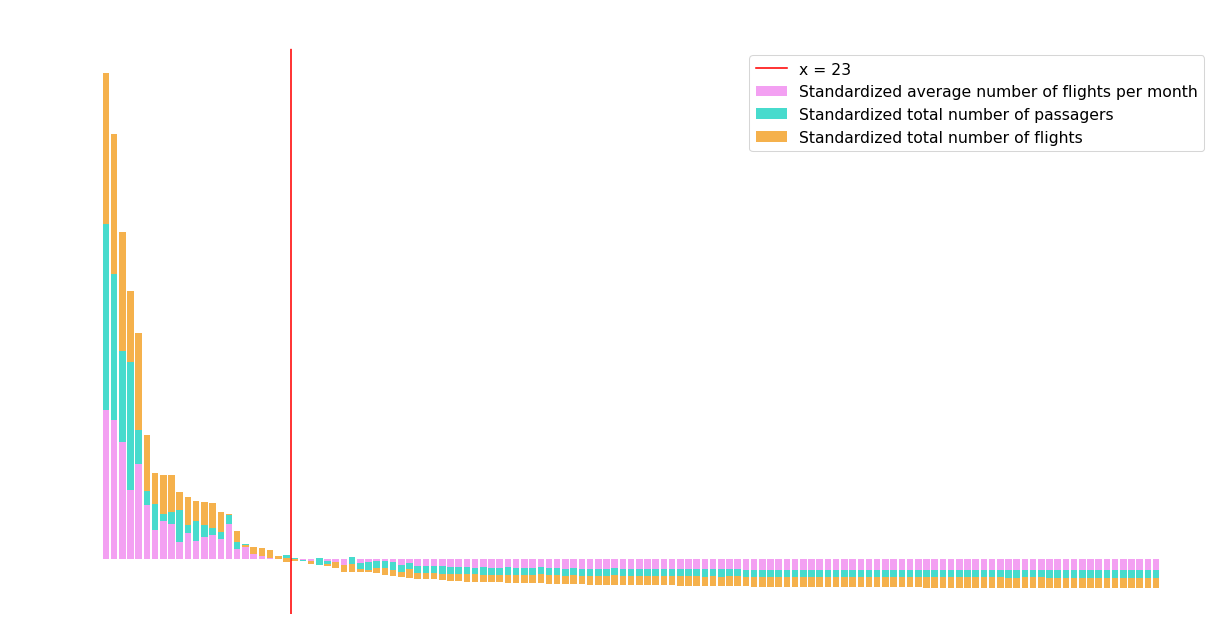

In [59]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.get_xaxis().set_visible(False)
ax.bar(airlines_choice['UNIQUE_CARRIER_NAME'], airlines_choice['MOY_NB_FLIGHTS'], color = 'C1', label = 'Standardized average number of flights per month')
ax.bar(airlines_choice['UNIQUE_CARRIER_NAME'], airlines_choice['TOT_PASS_FLIGHTS'], bottom = airlines_choice['MOY_NB_FLIGHTS'], color = 'C2', label = 'Standardized total number of passagers')
ax.bar(airlines_choice['UNIQUE_CARRIER_NAME'], airlines_choice['TOT_NB_FLIGHTS'], bottom = airlines_choice['MOY_NB_FLIGHTS'] + airlines_choice['TOT_PASS_FLIGHTS'], color = 'C3', label = 'Standardized total number of flights')
ax.axvline(x=22.5, color='r', linestyle='-', label = 'x = 23')
ax.legend(prop={'size': 15})
ax.set_title("Vertical bar plot of all the US CARRIERS sorted by their total performance on the period 2014-2019", pad = 25)
fig.show()

The line we drew on the figure was to show where were the main air carriers we chose to keep for this dataset. Now let's have a deeper a look of who they are and what their score was :

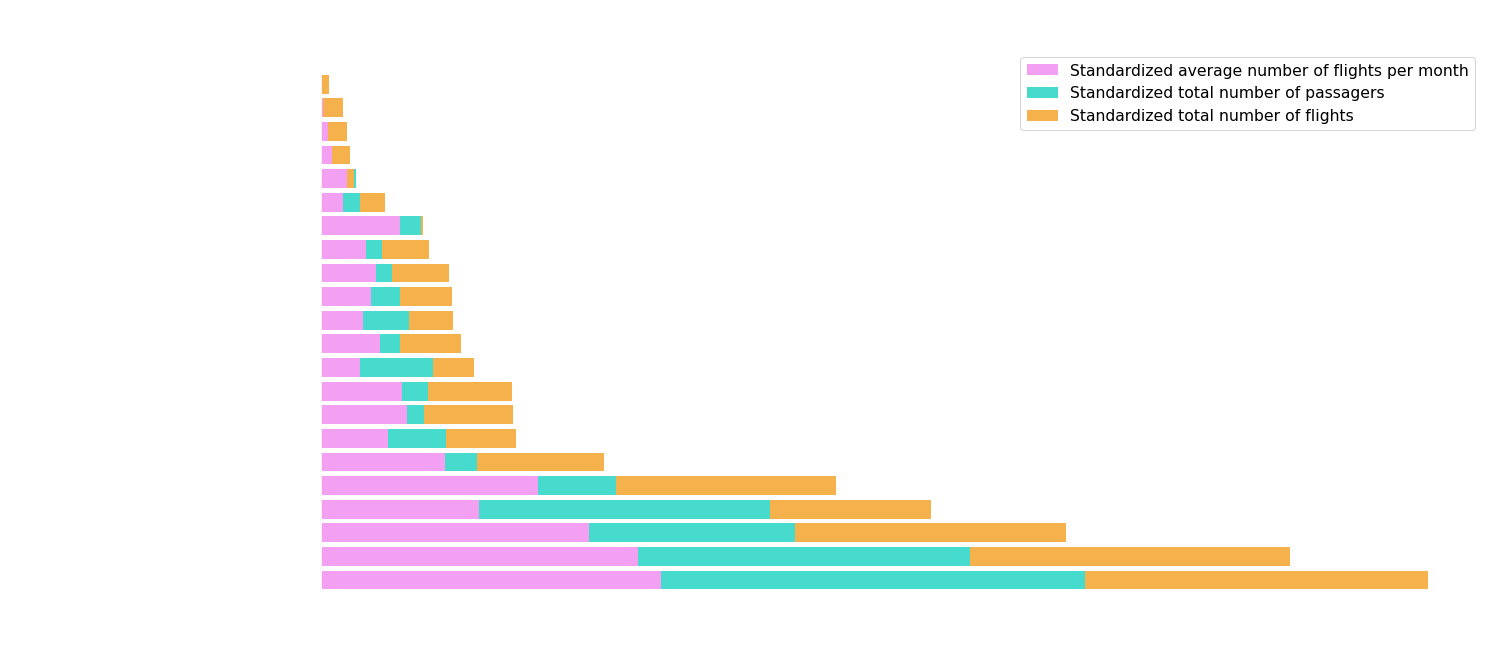

In [60]:
final_airlines = airlines_choice.iloc[:22, :].reset_index(drop=True)
fig, ax = plt.subplots(figsize=(20, 10))
ax.barh(final_airlines['UNIQUE_CARRIER_NAME'], final_airlines['MOY_NB_FLIGHTS'], color = 'C1', label = 'Standardized average number of flights per month')
ax.barh(final_airlines['UNIQUE_CARRIER_NAME'], final_airlines['TOT_PASS_FLIGHTS'], left = final_airlines['MOY_NB_FLIGHTS'], color = 'C2', label = 'Standardized total number of passagers')
ax.barh(final_airlines['UNIQUE_CARRIER_NAME'], final_airlines['TOT_NB_FLIGHTS'], left = final_airlines['MOY_NB_FLIGHTS'] + final_airlines['TOT_PASS_FLIGHTS'], color = 'C3', label = 'Standardized total number of flights')
ax.legend(prop={'size': 15})
ax.set_title("Horizontal bar plot of the main carriers (22) over the period 2014-2020", fontsize = 20, pad = 25)
fig.show()

## Train Dataset Decomposition <a name='decomp'></a>
---
Let's cut our dataset into smaller pieces so we can have a clearer view of what we'll be working on.

In [61]:
#a changer pour utilise celle de problem.py
X = pd.read_csv('data/train/features.csv', index_col=0)
X.head()

,UNIQUE_CARRIER_NAME,DATE,194,26,339,35,359,406,416,461,482,530,608,612,614,616,617,619,622,623,624,625,626,627,629,631,634,637,638,644,650,654,655,656,673,674,675,676,677,678,687,694,696,698,699,721,722,723,819,822,837,838,839,...,NB_FLIGHTS,PMI,Price,Q1_FREIGHT,Q1_MAIL,Q1_PASSENGERS,Q1_PAYLOAD,Q3_FREIGHT,Q3_MAIL,Q3_PASSENGERS,Q3_PAYLOAD,STD_FREIGHT,STD_MAIL,STD_PASSENGERS,STD_PAYLOAD,TOP1_DEST,TOP1_PRCP,TOP1_SNOW,TOP1_TAVG,TOP1_TMAX,TOP1_TSUN,TOP1_WSPD,TOP2_DEST,TOP2_PRCP,TOP2_SNOW,TOP2_TAVG,TOP2_TMAX,TOP2_TSUN,TOP2_WSPD,TOP3_DEST,TOP3_PRCP,TOP3_SNOW,TOP3_TAVG,TOP3_TMAX,TOP3_TSUN,TOP3_WSPD,TOP4_DEST,TOP4_PRCP,TOP4_SNOW,TOP4_TAVG,TOP4_TMAX,TOP4_TSUN,TOP4_WSPD,TOP5_DEST,TOP5_PRCP,TOP5_SNOW,TOP5_TAVG,TOP5_TMAX,TOP5_TSUN,TOP5_WSPD,TOP_1_DEST_FQ,UNEMPLOYMENT,LOAD_FACTOR
0,Air Wisconsin Airlines Corp,2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.0,0.0,0.0,0.00,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,315,50.7,97.41,0.00,0.0,153.50,96248.0,394.00,0.00,2092.50,1576126.0,867.332886,35.657436,1443.956635,9.696895e+05,"Charlotte, NC",150.7,0.0,24.723333,34.4,0.0,10.083333,"Philadelphia, PA",83.1,6.428571,2.657143,19.4,0.0,15.271429,"Washington, DC",126.3,0.0,21.138710,33.9,0.0,13.696774,"Boston, MA",100.0,0.000000,20.596667,35.6,0.0,14.920000,"Scranton/Wilkes-Barre, PA",76.1,0.000000,19.480000,33.3,0.0,9.056667,0.155556,7.8%,0.694164
1,Alaska Airlines Inc.,2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.167,0.356,0.0,0.333,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.144,0.0,0.0,0.0,0.00,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,444,50.7,97.41,183.25,0.0,384.75,141475.0,11659.25,1.25,4185.25,1313780.0,47218.189711,29506.552452,3734.144798,1.200548e+06,"Seattle, WA",97.3,0.0,7.019355,16.1,0.0,12.438710,"Anchorage, AK",20.9,465.483871,-2.345161,5.6,0.0,8.900000,"Portland, OR",114.1,0.0,7.543333,17.8,0.0,11.816667,"Juneau, AK",256.4,0.000000,7.148387,13.3,0.0,12.970968,"Palm Springs, CA",0.0,0.000000,18.861290,34.4,0.0,6.703333,0.247748,7.8%,0.829975
2,Allegiant Air,2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.048,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.012,0.940,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,482,50.7,97.41,0.00,0.0,340.00,90600.0,0.00,0.00,1377.00,306000.0,0.000000,0.000000,802.760251,1.869837e+05,"Las Vegas, NV",57.4,0.0,20.403333,32.8,0.0,13.340000,"Sanford, FL",96.7,0.000000,15.009677,28.3,0.0,12.758065,"Phoenix, AZ",7.8,0.0,13.846429,26.7,0.0,8.528571,"Wendover, UT",26.9,0.000000,3.453333,16.7,0.0,9.610000,"St. Petersburg, FL",228.3,0.000000,28.564516,34.4,0.0,8.448387,0.097510,7.8%,0.868898
3,American Airlines Inc.,2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.335,0.0,0.000,0.0,0.173,0.000,0.000,0.041,0.059,0.027,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.000,0.364,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,...,629,50.7,97.41,0.00,0.0,325.00,120200.0,6704.00,0.00,11808.00,4445700.0,139988.557494,12874.553621,9535.924198,3.240689e+06,"Dallas/Fort Worth, TX",88.6,0.0,10.266667,28.3,0.0,16.222581,"Chicago, IL",45.3,0.000000,13.587097,26.7,0.0,18.080645,"Miami, FL",322.9,0.0,27.774194,34.4,13909.0,12.438710,"Los Angeles, CA",6.1,0.000000,20.619355,35.0,0.0,9.480645,"New York, NY",128.8,21.935484,4.290323,22.8,0.0,20.238710,0.198728,7.8%,0.801683
4,Delta Air Lines Inc.,2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026,0.120,0.0,0.000,0.0,0.115,0.025,0.005,0.000,0.035,0.005,0.0,0.0,0.000,0.0,0.0,0.0,0.04,0.000,0.141,0.073,0.0,0.0,0.0,0.0,0.0,0.0,0.016,0.159,0.009,0.226,0.0,0.0,0.0,0.0,0.005,0.0,0.0,0.0,0.0,...,2329,50.7,97.41,0.00,0.0,127.00,40770.0,3830.00,975.00,3665.00,1183920.0,46160.765928,20904.331090,5532.201728

In [75]:
aircraft_type_frequency_df = X.iloc[:, np.r_[2:, 2:54]]
distance_features_df = X.iloc[:, np.r_[:2, 58:63]]
top_5_dest_features_df = X.iloc[:, np.r_[:2, 66:101]]
statistical_features_df = X.iloc[:, np.r_[:2, 54:58, 63:64]]
top_1_dest_frequency_df = X.iloc[:, np.r_[:2, 101]]
other_features = X.iloc[:, np.r_[:2, 64:66, 102:104]]

IndexError: positional indexers are out-of-bounds

## Aircraft Type Frequency Features <a name= 'aircraft'></a>
---
The first features we'll have a look at are the frequencies of aircrafts usage. Each aircraft type has a special code as column name in the dataset proposed by BTS, we chose to keep it as it is for the reading of the dataset and columns selection.

However, it is possible to change the code with the real name of the aircraft by using the data lookup table associated with them on the BTS website.

In [63]:
aircraft_type_frequency_df.head()

,UNIQUE_CARRIER_NAME,DATE,194,26,339,35,359,406,416,461,482,530,608,612,614,616,617,619,622,623,624,625,626,627,629,631,634,637,638,644,650,654,655,656,673,674,675,676,677,678,687,694,696,698,699,721,722,723,819,822,837,838,839,887
0,Air Wisconsin Airlines Corp,2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.0,0.0,0.0,0.00,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
1,Alaska Airlines Inc.,2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.167,0.356,0.0,0.333,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.144,0.0,0.0,0.0,0.00,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
2,Allegiant Air,2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.048,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.012,0.940,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
3,American Airlines Inc.,2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.335,0.0,0.000,0.0,0.173,0.000,0.000,0.041,0.059,0.027,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.000,0.364,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
4,Delta Air Lines Inc.,2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026,0.120,0.0,0.000,0.0,0.115,0.025,0.005,0.000,0.035,0.005,0.0,0.0,0.000,0.0,0.0,0.0,0.04,0.000,0.141,0.073,0.0,0.0,0.0,0.0,0.0,0.0,0.016,0.159,0.009,0.226,0.0,0.0,0.0,0.0,0.005,0.0,0.0,0.0,0.0,0.0


In [64]:
config_aircraft = pd.read_csv('data/L_AIRCRAFT_TYPE.csv_')
config_aircraft.head()

,Code,Description
0,7,Aero Commander 200
1,8,Aero Macchi AL-60
2,9,Aeronca 7-AC
3,10,Beech Bonanza 35A/C/D/E/G/H/J/K/S/V/ 36A
4,20,Bellanca CH-300


Let's change the name of the columns of our dataset to have a clearer view.

In [65]:
columns = aircraft_type_frequency_df.columns[2:]
new_columns = ['UNIQUE_CARRIER_NAME', 'DATE']
for column_name in columns:
  new_columns.append(config_aircraft[config_aircraft['Code']== int(column_name)]['Description'].values[0])
aircraft_type_frequency_df.columns = new_columns
aircraft_type_frequency_df.head()

,UNIQUE_CARRIER_NAME,DATE,Piper PA-31 (Navajo)/T-1020,Gipps Aero Ga8 Airvan,Airbus Industrie A330-900,Cessna C206/207/209/210 Stationair,Airbus Industrie A350-900,Beech 200 Super Kingair,Cessna 208 Caravan,Embraer EMB-120 Brasilia,De Havilland DHC8-400 Dash-8,Bombardier CRJ550,Boeing 717-200,Boeing 737-700/700LR/Max 7,Boeing 737-800,Boeing 737-500,Boeing 737-400,Boeing 737-300,Boeing 757-200,Boeing 757-300,Boeing 767-400/ER,Boeing 767-200/ER/EM,Boeing 767-300/300ER,Boeing 777-200ER/200LR/233LR,Canadair RJ-200ER /RJ-440,Canadair RJ-700,Boeing 737-900,Boeing 777-300/300ER/333ER,Canadair CRJ 900,Airbus Industrie A-318,McDonnell Douglas DC-9-50,McDonnell Douglas DC9 Super 87,McDonnell Douglas DC9 Super 80/MD81/82/83/88,McDonnell Douglas MD-90,Embraer ERJ-175,Embraer-135,Embraer-145,Embraer-140,Embraer-Emb-170,Embraer 190,Airbus Industrie A330-300,Airbus Industrie A320-100/200,Airbus Industrie A330-200,Airbus Industrie A319,Airbus Industrie A321/Lr,Airbus Industrie A321-200n,Airbus Industrie A320-200n,A200-100 BD-500-1A10,Boeing 747-400,Boeing 747SP,Boeing 787-10 Dreamliner,Boeing B737 Max 800,Boeing B737 Max 900,B787-800 Dreamliner
0,Air Wisconsin Airlines Corp,2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.000,0.000,0.000,0.000,0.000,0.000,1.0,0.0,0.000,0.0,0.0,0.0,0.00,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
1,Alaska Airlines Inc.,2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.167,0.356,0.0,0.333,0.0,0.000,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.144,0.0,0.0,0.0,0.00,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
2,Allegiant Air,2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.0,0.000,0.0,0.048,0.000,0.000,0.000,0.000,0.000,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.012,0.940,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
3,American Airlines Inc.,2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.335,0.0,0.000,0.0,0.173,0.000,0.000,0.041,0.059,0.027,0.0,0.0,0.000,0.0,0.0,0.0,0.00,0.000,0.364,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.000,0.000,0.000,0.000,0.0,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0
4,Delta Air Lines Inc.,2013-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.026,0.120,0.0,0.000,0.0,0.115,0.025,0.005,0.000,0.035,0.005,0.0,0.0,0.000,0.0,0.0,0.0,0.04,0.000,0.141,0.073,0.0,0.0,0.0,0.0,0.0,0.0,0.016,0.159,0.009,0.226,0.0,0.0,0.0,0.0,0.005,0.0,0.0,0.0,0.0,0.0


For the next visualization, we'll put our focus on one of the carriers, let's start with "SkyWest Airlines".

In [66]:
visualisation_df = aircraft_type_frequency_df[(aircraft_type_frequency_df['UNIQUE_CARRIER_NAME'] == 'SkyWest Airlines Inc.')]
visualisation_df['DATE'] = pd.to_datetime(visualisation_df['DATE'])
visualisation_df = visualisation_df.loc[:, (visualisation_df != 0).any(axis=0)]
visualisation_df.head()

,UNIQUE_CARRIER_NAME,DATE,Embraer EMB-120 Brasilia,Canadair RJ-200ER /RJ-440,Canadair RJ-700,Canadair CRJ 900,Embraer ERJ-175
16,SkyWest Airlines Inc.,2013-01-01,0.087,0.437,0.351,0.125,0.0
37,SkyWest Airlines Inc.,2013-02-01,0.080,0.444,0.356,0.120,0.0
58,SkyWest Airlines Inc.,2013-03-01,0.096,0.467,0.320,0.117,0.0
79,SkyWest Airlines Inc.,2013-04-01,0.078,0.447,0.360,0.115,0.0
100,SkyWest Airlines Inc.,2013-05-01,0.081,0.448,0.343,0.129,0.0


Let's have a visualisation of the time serie for the aircraft usage frequency by this airline.

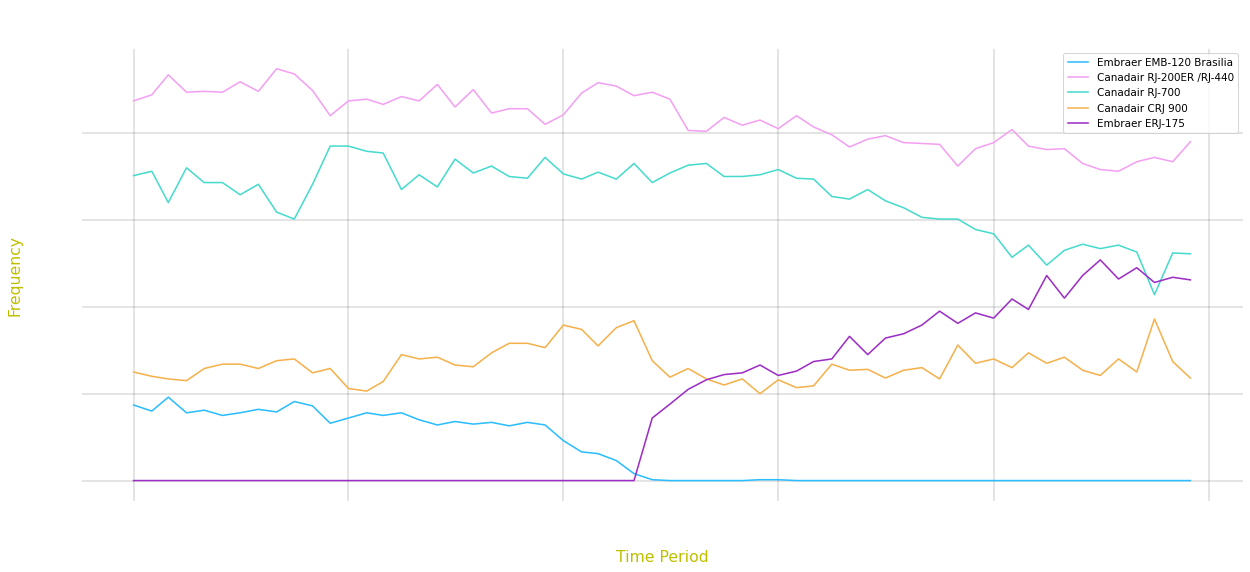

In [67]:
plt.figure()
plt.grid(True, linewidth=0.2, color='black', linestyle='-')
plt.plot(visualisation_df['DATE'], visualisation_df.iloc[:, 2:])
plt.legend(visualisation_df.iloc[:, 2:].columns)
plt.xlabel("Time Period", color = 'y', labelpad = 25)
plt.ylabel("Frequency", color = 'y', labelpad = 25)
plt.title("Aircraft Usage Frequency of SkyWest Airlines over the period 2014 - 2018", pad = 25)
plt.show()

## Distance Group Features <a name= 'distance'></a>
---
After having seen the aicraft type frequency features, let's look at the distance features we proposed to you. Each flight in the raw dataset is categorized according to its distance travelled by a distance interval in miles.

As we indexed our time serie by months, we performed a group by on the raw dataset and came up with the frequency of flights in each distance interval.

We chose to only keep the first 5 distance groups (the fifth one has a 2500 miles limit), most of the flights (over 95%) were contained in those 5 first distances groups while the remaining flights are contained inside the remaining 20 other distance groups.

In [68]:
distance_features_df.head()

,UNIQUE_CARRIER_NAME,DATE,AVG_PASSENGERS,AVG_PAYLOAD,DG_1,DG_2,DG_3
0,Air Wisconsin Airlines Corp,2013-01-01,1313.755556,9.131287e+05,0.743,0.251,0.006
1,Alaska Airlines Inc.,2013-01-01,3076.752252,1.061474e+06,0.200,0.378,0.144
2,Allegiant Air,2013-01-01,1092.663900,2.617477e+05,0.139,0.498,0.297
3,American Airlines Inc.,2013-01-01,8285.394277,2.923592e+06,0.173,0.267,0.313
4,Delta Air Lines Inc.,2013-01-01,3006.756977,1.010589e+06,0.293,0.375,0.156


The lookup table proposed by the Bureau of Transportation Statistics :

In [69]:
config_dist = pd.read_csv('data/L_DISTANCE_GROUP_500.csv_')
config_dist.head()

,Code,Description
0,1,Less Than 500 Miles
1,2,500-999 Miles
2,3,1000-1499 Miles
3,4,1500-1999 Miles
4,5,2000-2499 Miles


Let's simplify the dataset by having a look at a specific air carrier (Southwest Airlines Co., the biggest US Carrier) :

In [70]:
distance_features_df['DATE'] = pd.to_datetime(distance_features_df['DATE'])
distance_features_df = distance_features_df[distance_features_df['UNIQUE_CARRIER_NAME'] == 'Southwest Airlines Co.']
distance_features_df.head()

,UNIQUE_CARRIER_NAME,DATE,AVG_PASSENGERS,AVG_PAYLOAD,DG_1,DG_2,DG_3
17,Southwest Airlines Co.,2013-01-01,3721.671435,1.319949e+06,0.341,0.374,0.183
38,Southwest Airlines Co.,2013-02-01,3578.051348,1.199643e+06,0.323,0.385,0.187
59,Southwest Airlines Co.,2013-03-01,4458.766543,1.386610e+06,0.319,0.372,0.202
80,Southwest Airlines Co.,2013-04-01,3999.832223,1.304269e+06,0.330,0.370,0.194
101,Southwest Airlines Co.,2013-05-01,4699.533476,1.456491e+06,0.344,0.367,0.189


Same as before, let's have a look at the time series for the frequencies of distance groups of this carrier.

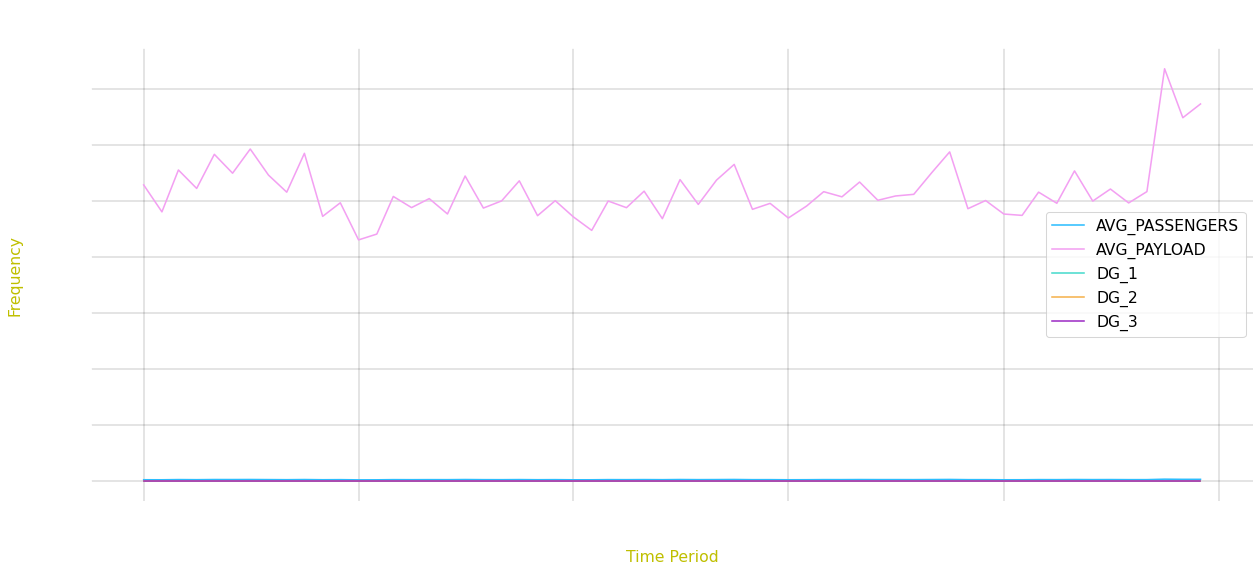

In [71]:
plt.figure()
plt.grid(True, linewidth=0.2, color='black', linestyle='-')
plt.plot(distance_features_df['DATE'], distance_features_df.iloc[:, 2:])
plt.legend(distance_features_df.iloc[:, 2:].columns, fontsize = 15)
plt.xlabel("Time Period", color = 'y', labelpad = 25)
plt.ylabel("Frequency", color = 'y', labelpad = 25)
plt.title("Frequency of flights by distance groups of Southwest Airlines over the period 2014 - 2018", pad = 25)
plt.show()

## Top 5 Destinations Features - Weather <a name='meteo'></a>
---
The raw BTS Dataset gave us access to origins and destinations of each flights. As we grouped our data by months, we found it interesting to extract the top 5 destinations and get data around them for each carrier for each month.

We'll enrich the data with the [weather data]("weather) introduced previously.

For each of the destinations, we get the average temperature for the month, the amout of precipations, the windspeed, the total sunshine duration, the snow depth, and the max temperature.

In [72]:
top_5_dest_features_df.head()

,UNIQUE_CARRIER_NAME,DATE,MAX_MAIL,MAX_PASSENGERS,MAX_PAYLOAD,MED_FREIGHT,MED_MAIL,MED_PASSENGERS,MED_PAYLOAD,MIN_FREIGHT,MIN_MAIL,MIN_PASSENGERS,MIN_PAYLOAD,NB_FLIGHTS,PMI,Price,Q1_FREIGHT,Q1_MAIL,Q1_PASSENGERS,Q1_PAYLOAD,Q3_FREIGHT,Q3_MAIL,Q3_PASSENGERS,Q3_PAYLOAD,STD_FREIGHT,STD_MAIL,STD_PASSENGERS,STD_PAYLOAD,TOP1_DEST,TOP1_PRCP,TOP1_SNOW,TOP1_TAVG,TOP1_TMAX,TOP1_TSUN,TOP1_WSPD,TOP2_DEST,TOP2_PRCP
0,Air Wisconsin Airlines Corp,2013-01-01,550.0,8300.0,4860856.0,0.0,0.0,892.0,625650.0,0.0,0.0,0.0,24062.0,315,50.7,97.41,0.00,0.0,153.50,96248.0,394.00,0.00,2092.50,1576126.0,867.332886,35.657436,1443.956635,9.696895e+05,"Charlotte, NC",150.7,0.0,24.723333,34.4,0.0,10.083333,"Philadelphia, PA",83.1
1,Alaska Airlines Inc.,2013-01-01,442832.0,21421.0,6623400.0,2234.0,0.0,1950.0,818712.5,0.0,0.0,8.0,34500.0,444,50.7,97.41,183.25,0.0,384.75,141475.0,11659.25,1.25,4185.25,1313780.0,47218.189711,29506.552452,3734.144798,1.200548e+06,"Seattle, WA",97.3,0.0,7.019355,16.1,0.0,12.438710,"Anchorage, AK",20.9
2,Allegiant Air,2013-01-01,0.0,4838.0,1088000.0,0.0,0.0,1178.0,272000.0,0.0,0.0,2.0,27000.0,482,50.7,97.41,0.00,0.0,340.00,90600.0,0.00,0.00,1377.00,306000.0,0.000000,0.000000,802.760251,1.869837e+05,"Las Vegas, NV",57.4,0.0,20.403333,32.8,0.0,13.340000,"Sanford, FL",96.7
3,American Airlines Inc.,2013-01-01,151481.0,50897.0,17291300.0,300.0,0.0,5123.0,2098200.0,0.0,0.0,0.0,35300.0,629,50.7,97.41,0.00,0.0,325.00,120200.0,6704.00,0.00,11808.00,4445700.0,139988.557494,12874.553621,9535.924198,3.240689e+06,"Dallas/Fort Worth, TX",88.6,0.0,10.266667,28.3,0.0,16.222581,"Chicago, IL",45.3
4,Delta Air Lines Inc.,2013-01-01,387655.0,55162.0,21057852.0,325.0,0.0,462.0,157718.0,0.0,0.0,0.0,20334.0,2329,50.7,97.41,0.00,0.0,127.00,40770.0,3830.00,975.00,3665.00,1183920.0,46160.765928,20904.331090,5532.201728,1.838179e+06,"Atlanta, GA",149.7,0.0,17.023333,28.9,0.0,14.503333,"Minneapolis, MN",76.1


Let's get the data for a single air carrier, "SkyWest Airlines" again as an example.

In [73]:
# Get Data for a certain company and reindex columns so they are sorted
top_5_dest_features_df = top_5_dest_features_df[top_5_dest_features_df['UNIQUE_CARRIER_NAME'] == 'SkyWest Airlines Inc.']
top_5_dest_features_df['DATE'] = pd.to_datetime(top_5_dest_features_df['DATE'])
top_5_dest_features_df.head()

,UNIQUE_CARRIER_NAME,DATE,MAX_MAIL,MAX_PASSENGERS,MAX_PAYLOAD,MED_FREIGHT,MED_MAIL,MED_PASSENGERS,MED_PAYLOAD,MIN_FREIGHT,MIN_MAIL,MIN_PASSENGERS,MIN_PAYLOAD,NB_FLIGHTS,PMI,Price,Q1_FREIGHT,Q1_MAIL,Q1_PASSENGERS,Q1_PAYLOAD,Q3_FREIGHT,Q3_MAIL,Q3_PASSENGERS,Q3_PAYLOAD,STD_FREIGHT,STD_MAIL,STD_PASSENGERS,STD_PAYLOAD,TOP1_DEST,TOP1_PRCP,TOP1_SNOW,TOP1_TAVG,TOP1_TMAX,TOP1_TSUN,TOP1_WSPD,TOP2_DEST,TOP2_PRCP
16,SkyWest Airlines Inc.,2013-01-01,0.0,12479.0,4776670.0,0.0,0.0,857.0,352500.0,0.0,0.0,0.0,7543.0,1379,50.7,97.41,0.0,0.0,98.50,35880.00,0.0,0.0,2035.00,729000.00,0.0,0.0,1812.411325,617639.685146,"Salt Lake City, UT",27.1,41.071429,4.014286,16.7,0.0,13.575000,"Denver, CO",128.2
37,SkyWest Airlines Inc.,2013-02-01,0.0,12098.0,4622965.0,0.0,0.0,875.0,337500.0,0.0,0.0,0.0,7543.0,1311,53.1,91.83,0.0,0.0,147.50,54000.00,0.0,0.0,2026.50,706580.00,0.0,0.0,1716.064329,570391.257487,"Salt Lake City, UT",65.8,18.709677,7.761290,22.8,0.0,13.658065,"Denver, CO",0.0
58,SkyWest Airlines Inc.,2013-03-01,0.0,18223.0,5524960.0,0.0,0.0,1347.0,446770.0,0.0,0.0,0.0,7543.0,1245,54.2,97.23,0.0,0.0,197.00,67500.00,0.0,0.0,2654.00,843000.00,0.0,0.0,2056.094801,664471.337233,"Salt Lake City, UT",48.6,0.000000,13.060000,30.6,0.0,14.360000,"Denver, CO",0.0
79,SkyWest Airlines Inc.,2013-04-01,0.0,18051.0,5589280.0,0.0,0.0,1130.0,391500.0,0.0,0.0,0.0,7543.0,1276,51.3,93.13,0.0,0.0,221.25,81000.00,0.0,0.0,2406.25,774250.00,0.0,0.0,1894.623804,616415.524237,"Salt Lake City, UT",32.1,0.000000,17.845161,32.2,0.0,12.687097,"Denver, CO",70.8
100,SkyWest Airlines Inc.,2013-05-01,0.0,18968.0,5949920.0,0.0,0.0,1265.0,418500.0,0.0,0.0,0.0,7543.0,1284,50.7,91.61,0.0,0.0,232.00,71668.75,0.0,0.0,2540.50,806650.25,0.0,0.0,1965.053632,631541.830804,"Salt Lake City, UT",1.3,0.000000,24.236667,36.1,0.0,15.500000,"Denver, CO",234.4


We propose to you 3 visualisations of some time series weather averages over the monthly top 5 destinations of "SkyWest Airlines". 

In [74]:
df_tavg = top_5_dest_features_df[['DATE','TOP1_TAVG', 'TOP2_TAVG', 'TOP3_TAVG', 'TOP4_TAVG', 'TOP5_TAVG']]
avg_tmp = df_tavg.iloc[:, 1:].mean(axis=1)
df_tavg['AVG'] = avg_tmp
df_tavg.head()

KeyError: "['TOP3_TAVG', 'TOP5_TAVG', 'TOP4_TAVG', 'TOP2_TAVG'] not in index"

In [50]:
df_prcp = top_5_dest_features_df[['DATE','TOP1_PRCP', 'TOP2_PRCP', 'TOP3_PRCP', 'TOP4_PRCP', 'TOP5_PRCP']]
avg_prcp = df_prcp.iloc[:, 1:].mean(axis=1)
df_prcp['AVG'] = avg_prcp
df_prcp.head()

KeyError: "['TOP3_PRCP', 'TOP5_PRCP', 'TOP4_PRCP'] not in index"

In [ ]:
df_wspd = top_5_dest_features_df[['DATE','TOP1_WSPD', 'TOP2_WSPD', 'TOP3_WSPD', 'TOP4_WSPD', 'TOP5_WSPD']]
avg_wspd = df_wspd.iloc[:, 1:].mean(axis=1)
df_wspd.loc[:, 'AVG'] = avg_wspd
df_wspd.head()

,DATE,TOP1_WSPD,TOP2_WSPD,TOP3_WSPD,TOP4_WSPD,TOP5_WSPD,AVG
16,2014-01-01,13.300000,0.000000,18.226667,13.076667,12.226667,11.366000
38,2014-02-01,13.876667,0.000000,18.313333,9.751613,13.425806,11.073484
60,2014-03-01,13.445161,0.000000,17.019355,12.236667,9.790323,10.498301
82,2014-04-01,12.951613,0.000000,18.686207,12.996774,9.626667,10.852252
104,2014-05-01,0.000000,12.616667,17.030000,11.787097,13.180645,10.922882


After having calculated the monthly averages of some weather datas for our carrier, let's make some visualizations of these time series.

We'll see some logical patterns over the years for the top 5 destinations datas of SkyWest Airlines.

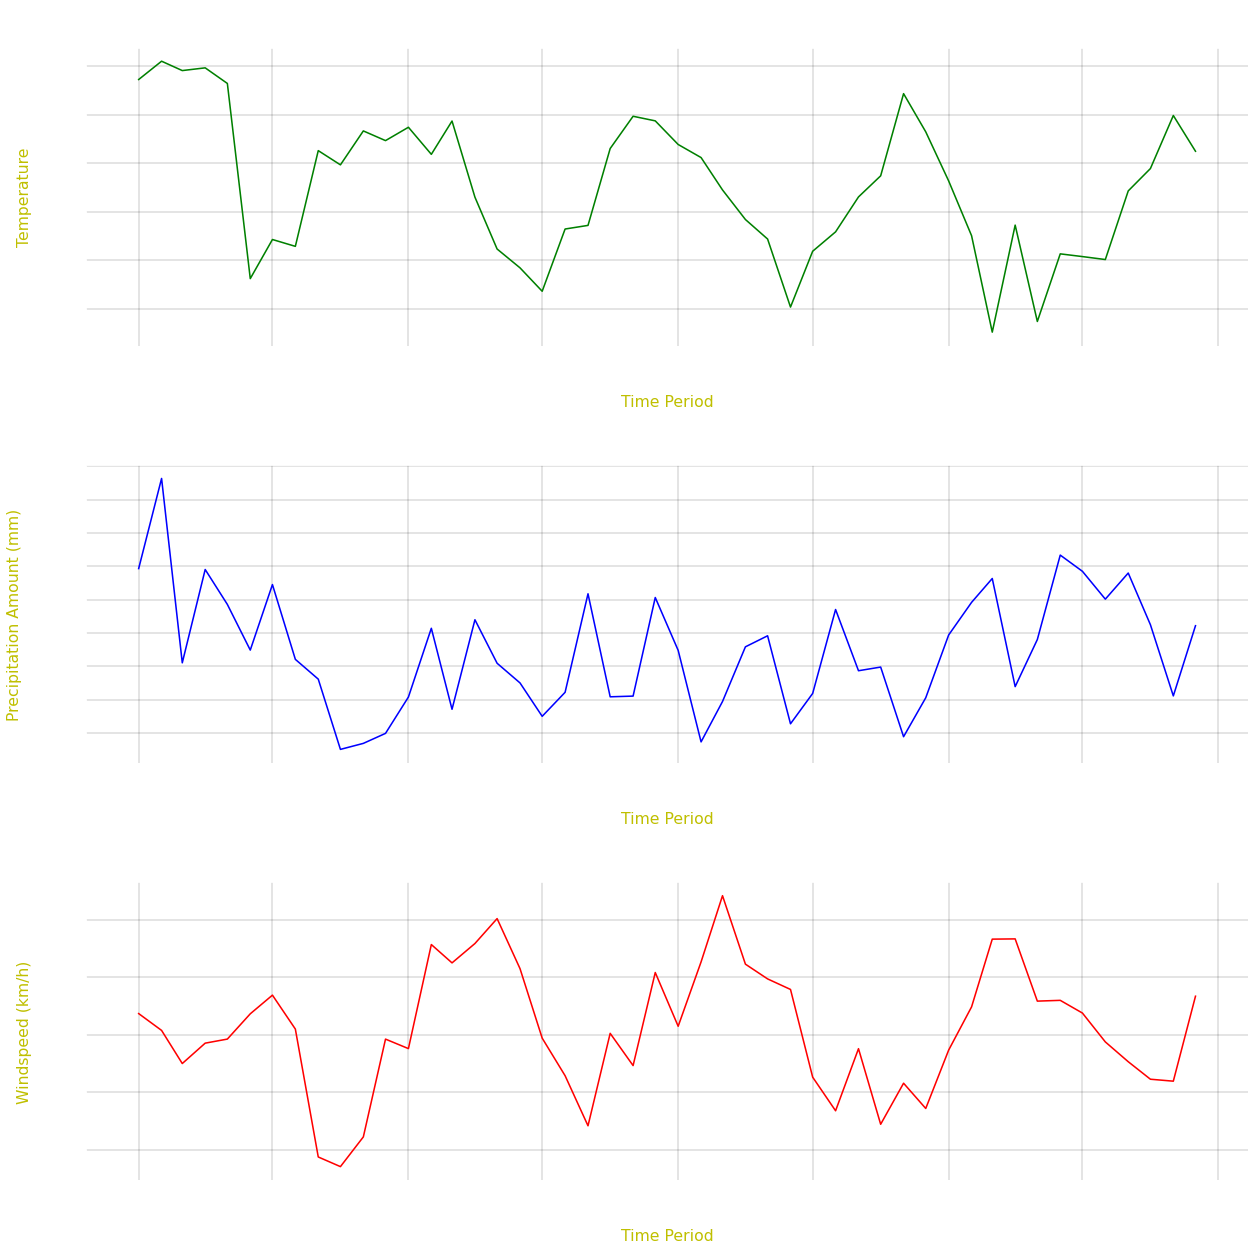

In [ ]:
fig, axs = plt.subplots(3, figsize=(20, 20))
fig.subplots_adjust(hspace = 0.4)
axs[0].grid(True, linewidth=0.2, color='black', linestyle='-')
axs[0].plot(df_tavg['DATE'], avg_tmp, 'g')
axs[0].set_xlabel("Time Period", color = 'y', labelpad = 25)
axs[0].set_ylabel("Temperature", color = 'y', labelpad = 25)
axs[0].set_title("Average Temperature among top 5 destinations of SkyWest Airlines over the period 2014 - 2018", pad = 25)
axs[1].grid(True, linewidth=0.2, color='black', linestyle='-')
axs[1].plot(df_tavg['DATE'], avg_prcp, 'b')
axs[1].set_xlabel("Time Period", color = 'y', labelpad = 25)
axs[1].set_ylabel("Precipitation Amount (mm)", color = 'y', labelpad = 25)
axs[1].set_title("Average precipitation amount among top 5 destinations of SkyWest Airlines over the period 2014 - 2018", pad = 25)
axs[2].grid(True, linewidth=0.2, color='black', linestyle='-')
axs[2].plot(df_tavg['DATE'], avg_wspd, 'r')
axs[2].set_xlabel("Time Period", color = 'y', labelpad = 25)
axs[2].set_ylabel("Windspeed (km/h)", color = 'y', labelpad = 25)
axs[2].set_title("Average windspeed among top 5 destinations of SkyWest Airlines over the period 2014 - 2018", pad = 25)
fig.show()

## Statistical Features <a name='stats'></a>
---
We added some statistical features (mostly means), as we grouped the raw dataset by month, we were able to retrieve interesting datas for each companies for each month, like average distance travelled, average freight, etc...

In [ ]:
statistical_features_df['DATE'] = pd.to_datetime(statistical_features_df['DATE'])
statistical_features_df.head()

,UNIQUE_CARRIER_NAME,DATE,AVG_DIST,AVG_FREIGHT,AVG_MAIL,AVG_PAYLOAD,NB_FLIGHTS
0,Air Wisconsin Airlines Corp,2014-01-01,404.053512,354.642140,6.591973,8.582344e+05,299
1,Alaska Airlines Inc.,2014-01-01,1173.775510,13008.870130,2729.788497,9.040299e+05,539
2,Allegiant Air,2014-01-01,966.379371,0.000000,0.000000,3.336490e+05,572
3,American Airlines Inc.,2014-01-01,1123.165939,26116.628821,1301.879185,2.653638e+06,687
4,Delta Air Lines Inc.,2014-01-01,904.897127,7577.173525,6264.973214,8.985811e+05,2576


In [ ]:
statistical_features_df = statistical_features_df[statistical_features_df['UNIQUE_CARRIER_NAME'] == 'Delta Air Lines Inc.']
statistical_features_df.head()

,UNIQUE_CARRIER_NAME,DATE,AVG_DIST,AVG_FREIGHT,AVG_MAIL,AVG_PAYLOAD,NB_FLIGHTS
4,Delta Air Lines Inc.,2014-01-01,904.897127,7577.173525,6264.973214,8.985811e+05,2576
26,Delta Air Lines Inc.,2014-02-01,911.509735,8773.143363,5667.393363,9.689106e+05,2260
48,Delta Air Lines Inc.,2014-03-01,899.996296,9717.263786,6183.986420,1.129333e+06,2430
70,Delta Air Lines Inc.,2014-04-01,852.755374,9194.553740,5825.522786,1.186201e+06,2326
92,Delta Air Lines Inc.,2014-05-01,870.864007,10662.920206,5158.264264,1.174597e+06,2331


For the visualizations of statistical features, we chose to use the Delta Air Lines Carrier, one of the most important one among the top air carriers.
We'll plot every statistical features as time series to see if we can visually see year pattern, trends and evolution over the years.

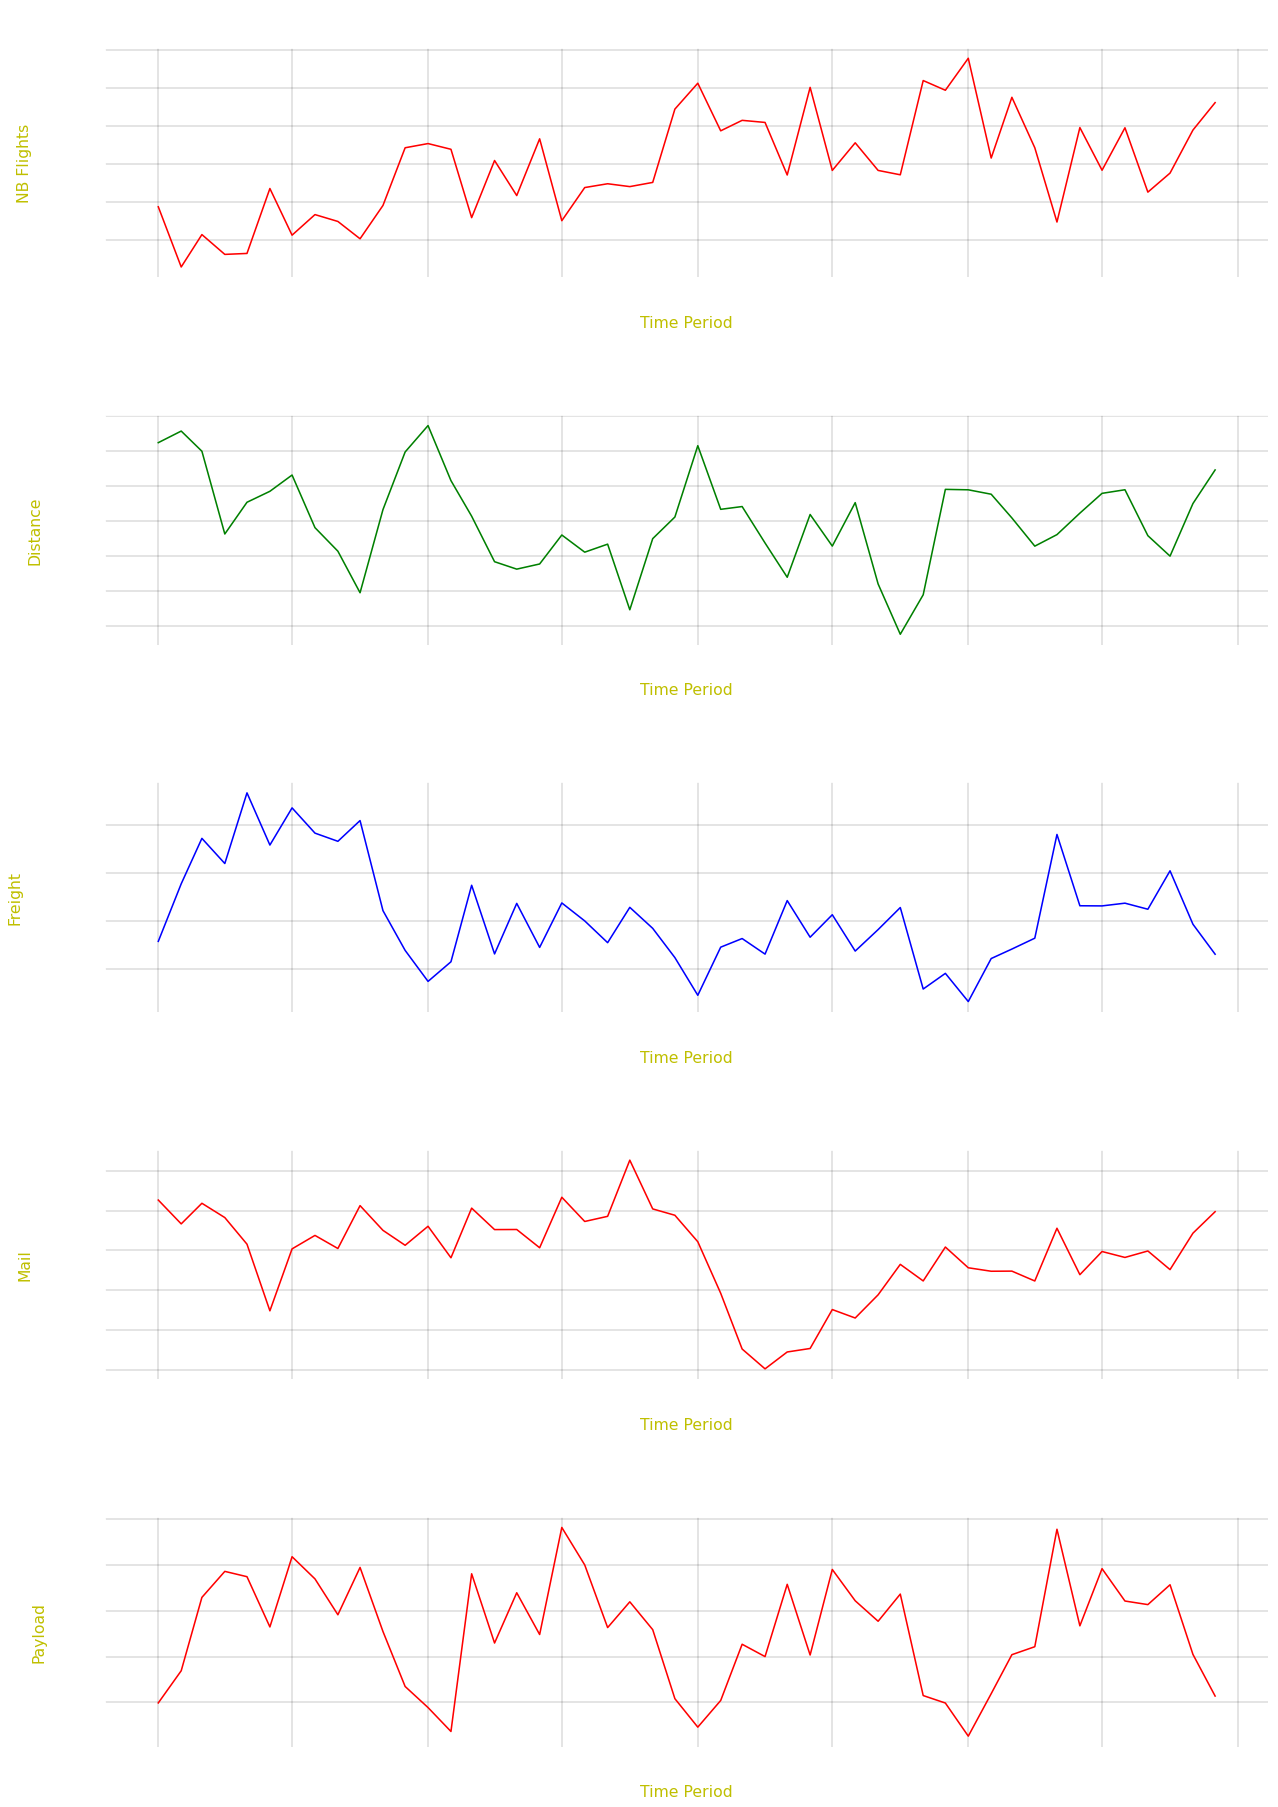

In [ ]:
fig, axs = plt.subplots(5, figsize=(20, 30))
fig.subplots_adjust(hspace = 0.6)

for ax in axs:
  ax.grid(True, linewidth=0.2, color='black', linestyle='-')
  ax.set_xlabel("Time Period", color = 'y', labelpad = 15)

axs[0].plot(statistical_features_df['DATE'], statistical_features_df['NB_FLIGHTS'], 'r')
axs[0].set_ylabel("NB Flights", color = 'y', labelpad = 25)
axs[0].set_title("Number of Flights Evolution of Delta Air Lines over the period 2014 - 2018", pad = 25)

axs[1].plot(statistical_features_df['DATE'], statistical_features_df['AVG_DIST'], 'g')
axs[1].set_ylabel("Distance", color = 'y', labelpad = 25)
axs[1].set_title("Average Distance Evolution of Delta Air Lines over the period 2014 - 2018", pad = 25)

axs[2].plot(statistical_features_df['DATE'], statistical_features_df['AVG_FREIGHT'], 'b')
axs[2].set_ylabel("Freight", color = 'y', labelpad = 25)
axs[2].set_title("Average Freight Evolution of Delta Air Lines over the period 2014 - 2018", pad = 25)

axs[3].plot(statistical_features_df['DATE'], statistical_features_df['AVG_MAIL'], 'r')
axs[3].set_ylabel("Mail", color = 'y', labelpad = 25)
axs[3].set_title("Average Mail Evolution of Delta Air Lines over the period 2014 - 2018", pad = 25)

axs[4].plot(statistical_features_df['DATE'], statistical_features_df['AVG_PAYLOAD'], 'r')
axs[4].set_ylabel("Payload", color = 'y', labelpad = 25)
axs[4].set_title("Average Payload Evolution of Delta Air Lines over the period 2014 - 2018", pad = 25)
fig.show()

## Top 1 Destination Frequency Feature <a name='top1'></a>
---
A little added feature was the frequency of flights of the monthly top 1 destination for our carriers. The idea behind this feature is to know the importance of the top 1 destination. The higher the frequency, the higher important the destination is, as more flights were programmed for this destination for a particular period of time.

In [ ]:
top_1_dest_frequency_df.head()

,UNIQUE_CARRIER_NAME,DATE,TOP_1_DEST_FQ
0,Air Wisconsin Airlines Corp,2014-01-01,0.163880
1,Alaska Airlines Inc.,2014-01-01,0.224490
2,Allegiant Air,2014-01-01,0.120629
3,American Airlines Inc.,2014-01-01,0.197962
4,Delta Air Lines Inc.,2014-01-01,0.189053


In [ ]:
carriers = ['American Airlines Inc.', 'SkyWest Airlines Inc.', 'Delta Air Lines Inc.', 'Southwest Airlines Co.']
top_1_dest_frequency_df = top_1_dest_frequency_df[top_1_dest_frequency_df['UNIQUE_CARRIER_NAME'].isin(carriers)]
top_1_dest_frequency_df['DATE'] = pd.to_datetime(top_1_dest_frequency_df['DATE'])
top_1_dest_frequency_df.head()

,UNIQUE_CARRIER_NAME,DATE,TOP_1_DEST_FQ
3,American Airlines Inc.,2014-01-01,0.197962
4,Delta Air Lines Inc.,2014-01-01,0.189053
16,SkyWest Airlines Inc.,2014-01-01,0.086109
17,Southwest Airlines Co.,2014-01-01,0.058928
25,American Airlines Inc.,2014-02-01,0.198251


For our visualization, we'll look at some of the largest air carriers in our top companies. We'll have a time serie of the evolution of the frequency for the top 1 destination over the period of our datas.

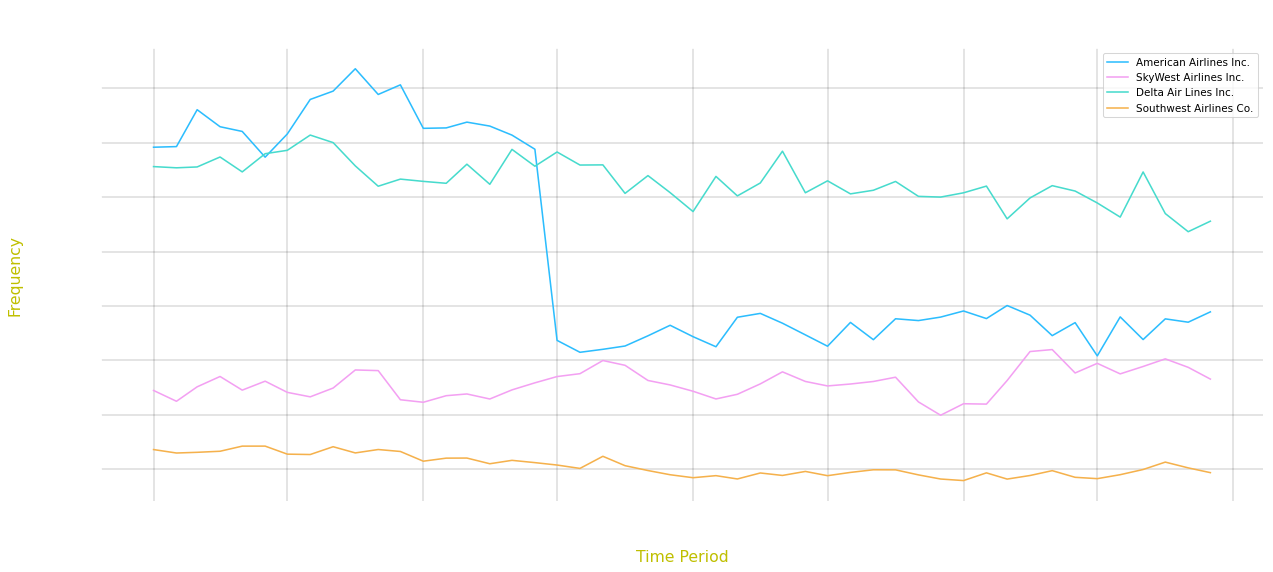

In [ ]:
plt.figure()
for carrier in carriers:
  tmp = top_1_dest_frequency_df[top_1_dest_frequency_df['UNIQUE_CARRIER_NAME'] == carrier]
  plt.grid(True, linewidth=0.2, color='black', linestyle='-')
  plt.plot(tmp['DATE'], tmp['TOP_1_DEST_FQ'])
plt.legend(carriers)
plt.xlabel("Time Period", color = 'y', labelpad = 25)
plt.ylabel("Frequency", color = 'y', labelpad = 25)
plt.title("Flights Frequency of top 1 destination for some air carriers over the period 2014 - 2018", pad = 25)
plt.show()

## Seasonality of the Load Factor <a name='season'></a>
---
As for the majority of time series, it's very common to have seasonal representation for our data. We'll take a look at our response : the load factor for one carrier : Southwest Airlines.


In [ ]:
y = pd.read_csv('data/load_factor_seaso.csv', index_col=0)
y = y[y['UNIQUE_CARRIER_NAME'] == 'Southwest Airlines Co.']
y['DATE'] = pd.to_datetime(y['DATE'])
y.head()

,UNIQUE_CARRIER_NAME,DATE,LOAD_FACTOR
1020,Southwest Airlines Co.,2012-01-01,0.755852
1021,Southwest Airlines Co.,2012-02-01,0.760968
1022,Southwest Airlines Co.,2012-03-01,0.820013
1023,Southwest Airlines Co.,2012-04-01,0.798468
1024,Southwest Airlines Co.,2012-05-01,0.811836


In [ ]:
def plot_seaso(date,val,ts,nbr=6,bool_2020=False,quantile=False,retour=False):
  """
  #param
  date = 'date'
  val = 'value'
  ts = time_serie
  nbr = number of years
  bool_2020 = false means no 2020
  """
  #new columns
  ts['Month'] = ts[date].dt.month
  ts['Year'] = ts[date].dt.year
  if bool_2020 == False:
    ts = ts[ts['Year']<2020]
  #pivot table
  pivot_table = pd.pivot_table(ts, values=val, index=['Month'], columns=['Year'], aggfunc=np.sum)

  if quantile == False:
    pivot_table['b_sup'] = pivot_table.iloc[:,-6:-1].max(axis=1)
    pivot_table['b_inf'] = pivot_table.iloc[:,-7:-2].min(axis=1)
  else:
    pivot_table['b_inf'] = pivot_table.iloc[:,-6:-1].quantile(0.25,axis=1)
    pivot_table['b_sup'] = pivot_table.iloc[:,-7:-2].quantile(0.75,axis=1)
  pivot_table['5 Year Avg'] = pivot_table.iloc[:,-8:-3].mean(axis=1)
  #plot
  plot = go.Figure()
  title = "Seasonality Graph of the Southwest Airlines Carrier over the period 2012-2017"
  # Set the colors for the lines
  colors = ['#17becf','#e377c2','#ff7f0e','#2ca02c','darkblue','firebrick',
            '#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b',
            '#e377c2','#7f7f7f','#bcbd22','#17becf' ]
  # Create x-axis labels for the months
  months = ['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
  data = pivot_table
  plot.add_trace(go.Scatter(x=months, y=data['b_sup'],
                            fill=None,
                            mode=None,
                            line_color='gray',showlegend=False
                            ))
  plot.add_trace(go.Scatter(x=months, y=data['b_inf'],
                            fill='tonexty',
                            mode=None,
                            line_color='gray', showlegend=False
                            ))
  plot.add_trace(go.Scatter(x=months, y=data['5 Year Avg'], name='5 Year Avg',
                            line=dict(color='black', width=4, dash='dot')))


  for i in range(nbr):
      index = -3-i
      plot.add_trace(go.Scatter(x=months, y=data.iloc[:,index], name=data.columns[index],
                              line=dict(color=colors[i], width=4)))
  plot.update_layout(title=title,
                    xaxis_title='Month',
                    yaxis_title='Load factor',
                    template='plotly_white')
  plot.show()
  if retour == True:
    return pivot_table.iloc[:,index:]

This visualization not only contains the evolution of the load factor over the years, but also displays a range in which the load factor is expected to be in according to the data we got for the period. 
It is also interactive, so if you've executed the code on your own notebook, you can safely click on the legend on the right to switch off or switch on certain years. 

In [ ]:
plot_seaso('DATE', 'LOAD_FACTOR', y, 6, False, True, True)

Year,2012,2013,2014,2015,2016,b_inf,b_sup,5 Year Avg
Month,,,,,,,,
1,0.755852,0.729931,0.763500,0.752197,0.774138,0.746631,0.757764,0.750370
2,0.760968,0.759891,0.781737,0.800314,0.790302,0.760699,0.786381,0.775728
3,0.820013,0.819414,0.826802,0.846840,0.847039,0.819863,0.831812,0.828267
4,0.798468,0.776708,0.816332,0.832866,0.835631,0.793028,0.820466,0.806094
5,0.811836,0.819051,0.836807,0.846303,0.860726,0.817247,0.839181,0.828499
6,0.839168,0.848872,0.860936,0.862655,0.873773,0.846446,0.861366,0.852908
7,0.840198,0.838181,0.867528,0.876053,0.867584,0.839694,0.869660,0.855490
8,0.842628,0.814755,0.855648,0.854067,0.845806,0.835660,0.854462,0.841775
9,0.774822,0.771254,0.806698,0.829071,0.845707,0.773930,0.812291,0.795461


# Performance Metric <a name = 'metric'></a>

We are in the presence of a regression type of problem, so we considered using the `MSE` metric. However, we know that the `load factor` is a value contained between 0 and 1, so the mean squared error would give us a very low value, so we decided to use the RMSE to tackle this issue:

$ RMSE = \frac{1}{n}*\sum_{{i=0}}^n{(y_i* - y_i)^2} $

The only issue with that metric is the interpretability of the results. Even if it penalizes larger errors, which is a good thing, we can't interpret the real magnitude in the scale of the load factor, so we added `MAE` as a metric.

$ MAE = \frac{1}{n}*\sum_{{i=0}}^n{|y_i* - y_i|} $

Note: RMSE should remain your main metric to optimize against.




The cross validation scheme is almost identical to the [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html):

![](https://scikit-learn.org/stable/_images/sphx_glr_plot_cv_indices_010.png)

Except that it has a min train size of two years, and that the test set highlighted above is the validation set and not the test set.

To not influence you on how much window time in the past you should take to fit and predict, and to comply with the standards of train-valid-test scheme defined [here](https://github.com/paris-saclay-cds/ramp-workflow/blob/master/rampwf/utils/submission.py#L138), we explain how the fit/scores are calculated for each stage (we also advise you print min/max of dates in your fit/predict methods):
- For the train score, it compares your predictions values for dates on which your estimator was trained with (X_train\[train_indices\]), with the ground truth values y_train\[train_indices\]. This score is not the main indicator of performance since it makes prediction on the dates it has already seen.
- For the valid score, we pass the same X_train with one more year of data (cv_indices), and the score between your predictions and y_test\[cv_indices\] is calculated **only on this last year**. Hence, it constitutes the most accurate representation of our forecasting problem, which is fitting on $n$ months and forecasting/evalutating on the $[n+1, ..., n+12]$ months.
- For the test score, the score between your predictions and y_test is calculated on the whole X_test data meaning X_train + X_cv + 1 year. Since it predicts on data is hasn't seen too, it's naturally more relevant than the train score but less than the valid one.

# Ideas and starting kits <a name = 'ideas'></a>

In [ ]:
We will present here a few insights approaches that you will be able to test for the challenge.#

## SARIMA

One of the conventional approaches for time series is to use [(S)ARIMA(X) models](https://en.wikipedia.org/wiki/Autoregressive_integrated_moving_average), let's see this in practice:

A few notes:
- The fact that this is a time series prediction task makes it different from the other challenges, so we encourage you to understand clearly the problem and data available
- The main dataset contains a **lot** of features, on airlines and weather statistics and can be enriched with tweets for each of the airlines. It's not mandatory to use all the data and features, it's only required to predict the `LOAD_FACTOR` for the last year after the end of the X data.
- There are a lot of approcahes for dealing with time series. From "old" statistical and state space methods, to modified versions of machine learning algorithms for time series, even to sequential deep leaning methods, and each has advantages/drawbacks. One video that might be useful for modern time series approaches is [this one](https://www.youtube.com/watch?v=v5ijNXvlC5A), we recommment you highly to watch it!

# Submitting to RAMP <a name='sub'> <a>

The example solutions presented above are implemented in the submissions/**/estimator.py files. The code in this file defines a function called get_estimator() that returns a scikit-learn pipeline that performs the same steps as described above (for example for the sarima kit):

In [ ]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator
import statsmodels.api as sm


class SARIMAEstimator(BaseEstimator):
    def __init__(self, trend_orders=(0, 1, 0), seasonal_orders=(1, 0, 1, 4)):
        self.airline_models = {}
        self.trend_orders = trend_orders
        self.seasonal_orders = seasonal_orders

    def fit(self, X, y):
        X_features = X.features
        carriers = np.unique(X_features["UNIQUE_CARRIER_NAME"])

        for carrier in carriers:
            # subsetting X_df for current airiline
            X_used = X_features[X_features["UNIQUE_CARRIER_NAME"]
                                == carrier].copy()
            X_used.drop(columns="UNIQUE_CARRIER_NAME", inplace=True)
            X_used.set_index("DATE", inplace=True)

            # finding the indices in y corresponding to X_used
            y_used = pd.Series(y[np.where(
                X_features["UNIQUE_CARRIER_NAME"] == carrier)[0]])
            y_used.index = X_used.index

            # fitting and saving model for airline
            model = sm.tsa.statespace.SARIMAX(
                y_used,
                order=self.trend_orders,
                seasonal_order=self.seasonal_orders,
                enforce_stationarity=False,
                enforce_invertibility=False,
                freq="MS"
            )
            results = model.fit(disp=False)
            self.airline_models[carrier] = results
        return self

    def predict(self, X):
        X_features = X.features
        # get all unique carriers
        carriers = np.unique(X_features["UNIQUE_CARRIER_NAME"])
        # init a dataframe of predictions to align with dates and carriers
        predictions = pd.DataFrame(columns=["UNIQUE_CARRIER_NAME", "PRED"])
        # the prediction dates boundaries
        start_predict_date = min(X_features["DATE"])
        end_predict_date = max(X_features["DATE"])
        print(start_predict_date, end_predict_date)
        # prediction with the model for each carrier
        for carrier in carriers:
            # get forecast for number of months
            airline_model = self.airline_models[carrier]
            # out samples forecast for last year and in sample prediction for the rest
            load_factor_forecast = airline_model.predict(
                start=start_predict_date, end=end_predict_date
            )

            # subsetting dataframe for current airline
            y_pred_df = X_features[
                X_features["UNIQUE_CARRIER_NAME"] == carrier
            ][["UNIQUE_CARRIER_NAME", "DATE"]].copy()
            y_pred_df.set_index("DATE", inplace=True)
            y_pred_df["PRED"] = load_factor_forecast
            predictions = predictions.append(y_pred_df)

        return predictions["PRED"].values


def get_estimator():
    # just create the pipeline
    pipeline = Pipeline([
        ("SARIMAEstimator", SARIMAEstimator()),
    ])
    return pipeline


The get_estimator() should return an object (your algorithm) with a .fit() and a .predict() method, which will be evaluated on cross-validation according to the schema in the metric part. Other files and functions will only be read/executed if they are read/executed by get_estimator().

Once you have a submission ready, save your submission code in file named estimator.py, which should be stored in a folder (e.g., my_submission) within submissions (e.g., within submissions/my_submission/estimator.py). You can now test your code locally test with:

`ramp-test --submission <submission folder name>`
where <submission folder name> should be the name of the submission folder (e.g., my_submission).

What you should check:

- Make sure you have installed ramp-workflow locally (see above)
- Make sure that the python file estimator.py is in submissions/<submission folder>, and the train and test data are in data
- If you haven't yet, download the data by executing
  `python download_data.py`
Finally, make sure the local processing goes through by running the

`ramp-test --submission <submission folder>`

See the [online documentation](https://paris-saclay-cds.github.io/ramp-docs/ramp-workflow/stable/using_kits.html) for more details.